In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K
from sklearn.model_selection import train_test_split

%matplotlib inline

mcycle = pd.read_csv('mcycle.txt',delimiter='\t')

In [3]:
mcycle.times = (mcycle.times - mcycle.times.mean())/mcycle.times.std()
mcycle.accel = (mcycle.accel - mcycle.accel.mean())/mcycle.accel.std()

In [4]:
X, X_cal, y, y_cal = train_test_split(
    mcycle.times, mcycle.accel, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
model = Sequential()
model.add(Dense(units=10, input_dim=1, activation='relu'))
model.add(Dense(units=10, input_dim=1, activation='relu'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [6]:
model.fit(X_train.values, y_train.values, epochs=250, batch_size=4, verbose=0)
y_pred = model.predict(X_cal.values)
model.evaluate(X_cal.values, y_cal.values)

1/1 [==============================] - 0s 68ms/step - loss: 0.3999


0.3998980224132538

In [7]:
def tilted_loss(q, y, f):
    e = (y - f)
    return K.mean(K.maximum(q * e, (q - 1) * e), axis=-1)

In [8]:
def mcycleModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1, activation='relu'))
    model.add(Dense(units=10, input_dim=1, activation='relu'))
    model.add(Dense(1))

    return model

In [9]:
qs = [0.2, 0.8]

# implement the conformal quantile regression using 0.1 and 0.9 quantiles as the intervals
initial_upper = []
initial_lower = []
models = []

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adam')
    model.fit(X_train.values, y_train.values, epochs=250, batch_size=4, verbose=0)
    models.append(model)
    if (q == qs[0]):
        initial_lower = model.predict(X_cal.values)
    else:
        initial_upper = model.predict(X_cal.values)

1/1 [==============================] - 0s 32ms/step


In [10]:
import scipy.stats as st

In [11]:
# sort the calibration set and the predictions correspondingly for plotting
sorted_indices = np.argsort(X_cal.values, axis=0)
sorted_X_cal = X_cal.values[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]

# similarly, sort initial_upper and initial_lower by using sorted_indices
initial_upper = np.array(initial_upper)
initial_lower = np.array(initial_lower)
sorted_upper = initial_upper[sorted_indices]
sorted_lower = initial_lower[sorted_indices]

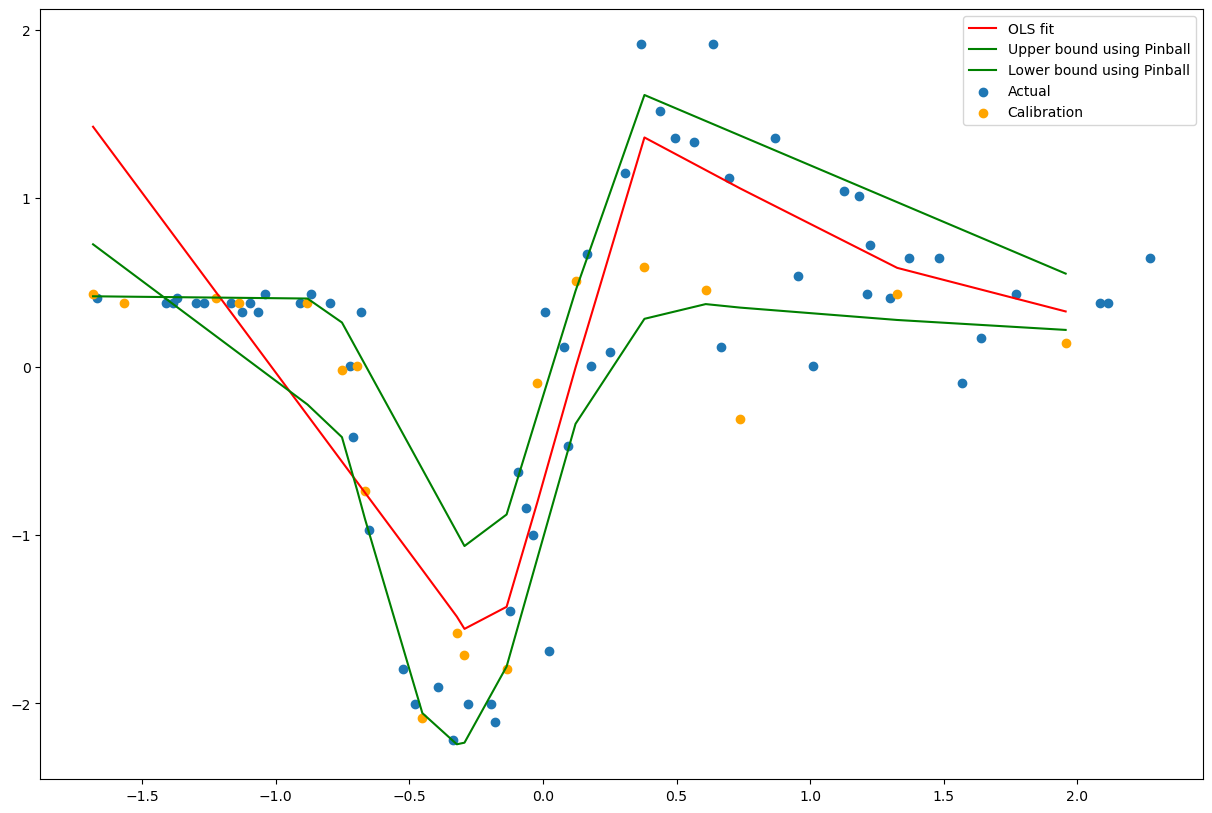

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(sorted_X_cal, sorted_y_pred, color='red', label='OLS fit')

plt.plot(sorted_X_cal, sorted_upper,
         color='green', label='Upper bound using Pinball')
plt.plot(sorted_X_cal, sorted_lower,
         color='green', label='Lower bound using Pinball')
plt.scatter(X_train, y_train, color='tab:blue', label='Actual')
plt.scatter(X_cal, y_cal, color='orange', label='Calibration')
plt.legend()
plt.show()

In [13]:
sorted_y_cal = y_cal.values[sorted_indices]


In [14]:
# calculate the errors list by taking max(lower - y_cal, y_cal - upper) for each calibration point
errors = []
for i in sorted_indices:
    errors.append(max(sorted_lower[i] - sorted_y_cal[i], sorted_y_cal[i] - sorted_upper[i]))




In [15]:
errors = [i[0] for i in errors]

In [16]:
errors = np.array(errors)

In [17]:
errors

array([-0.0266735 , -0.08543488,  0.02672935, -0.30727524,  0.660725  ,
        0.21262032, -0.28173018, -0.15400416,  0.01265478, -0.09015387,
        0.29511663, -0.60134   ,  0.07759114, -0.00463891,  0.06074542,
       -0.16768897, -0.03090447, -0.52047896,  0.18761428], dtype=float32)

In [18]:
q_hat = np.quantile(errors, 0.59)

In [19]:
q_hat

0.006083178520202623

In [20]:
# calculate the true confidence intervals of 80 percent so that we can compare our prediction intervals with them
q95 = st.norm.ppf(0.60)
sigma = 1
y_train_sigma = q95 * sigma * X_train
true_upper = y_train + y_train_sigma
true_lower = y_train - y_train_sigma

# sort the training set and the predictions correspondingly for plotting
sorted_indices = np.argsort(X_train.values, axis=0)
sorted_X_train = X_train.values[sorted_indices]
sorted_y_train = y_train.values[sorted_indices]

# similarly, sort true_upper and true_lower by using sorted_indices
true_upper = np.array(true_upper)
true_lower = np.array(true_lower)
sorted_true_upper = true_upper[sorted_indices]
sorted_true_lower = true_lower[sorted_indices]



In [21]:
pred_upper = []
pred_lower = []

y_lower = models[0].predict(X_test.values)
pred_lower.append(y_lower-q_hat)
y_higher = models[1].predict(X_test.values)
pred_upper.append(y_higher+q_hat)

1/1 [==============================] - 0s 15ms/step


In [22]:
sorted_indices_2 = np.argsort(X_test.values, axis=0)
sorted_x_test = X_test.values[sorted_indices_2]
sorted_pred_upper = pred_upper[0][sorted_indices_2]
sorted_pred_lower = pred_lower[0][sorted_indices_2]

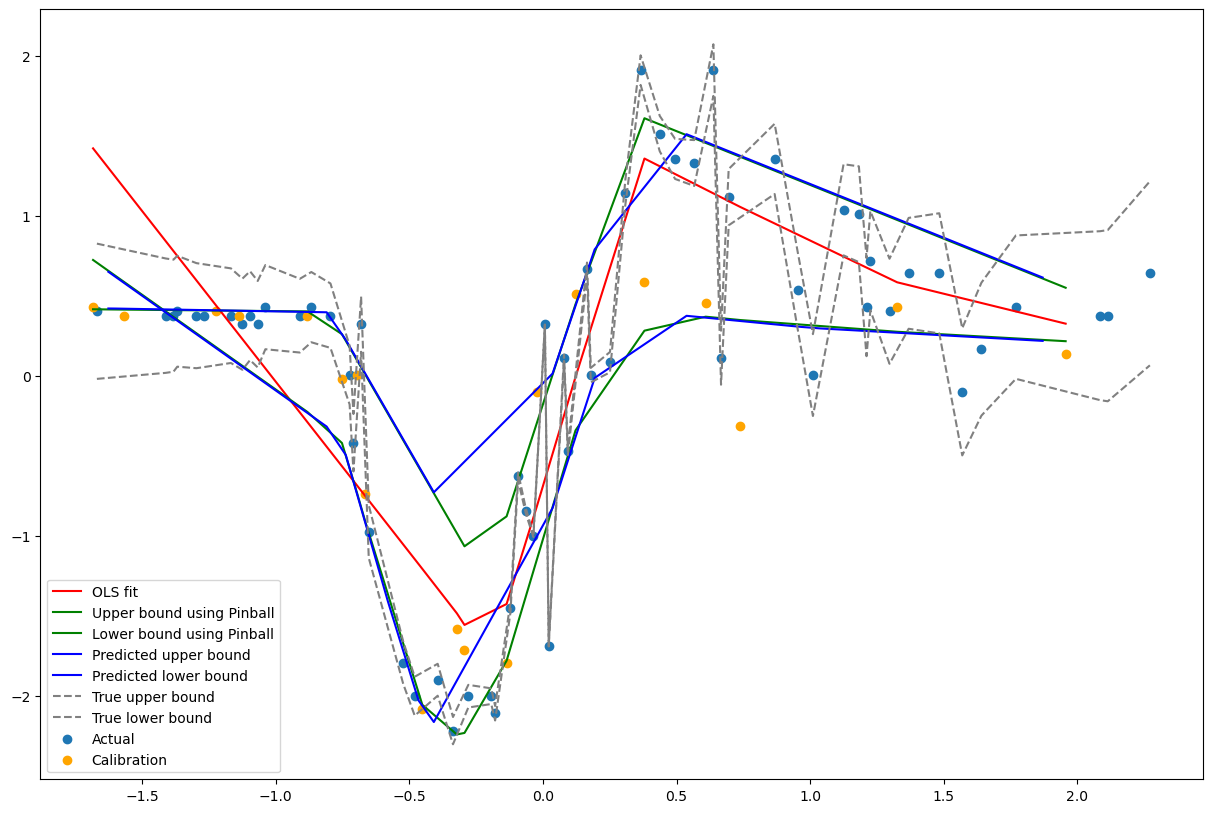

In [23]:
plt.figure(figsize=(15, 10))
plt.plot(sorted_X_cal, sorted_y_pred, color='red', label='OLS fit')

plt.plot(sorted_X_cal, sorted_upper,
         color='green', label='Upper bound using Pinball')
plt.plot(sorted_X_cal, sorted_lower,
         color='green', label='Lower bound using Pinball')
plt.plot(sorted_x_test, sorted_pred_upper,
         color='blue', label='Predicted upper bound')
plt.plot(sorted_x_test, sorted_pred_lower,
         color='blue', label='Predicted lower bound')
plt.plot(sorted_X_train, sorted_true_upper, color="gray", ls="--", label='True upper bound')
plt.plot(sorted_X_train, sorted_true_lower, color="gray", ls="--", label='True lower bound')
plt.scatter(X_train, y_train, color='tab:blue', label='Actual')
plt.scatter(X_cal, y_cal, color='orange', label='Calibration')
plt.legend()
plt.show()